In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from dask.distributed import Client, wait
from dask import array as darr

from pathlib import Path

import hextraj

from matplotlib import pyplot as plt
import cartopy
import seaborn as sns

## Parameters

We need to specify the hex projectoin.  The relevant parameters are stored in the connectivity matrix dataset.

In [2]:
# parameters

connectivity_matrix_file_path = "/gxfs_work/geomar/smomw400/git_projects/2022_north-sea_oysters/output_data/030_connection_count_05m/"
connectivity_matrix_file_pattern = "030_connection_count_05m_days-travelled-??_bio_agg.nc"

connectivity_matrix_file_out_path = "/gxfs_work/geomar/smomw400/git_projects/2022_north-sea_oysters/output_data/035_connection_count_05m/"
connectivity_matrix_file_out_pattern = "035_connection_count_05m_days-travelled-{dt:02d}_bio_phys_agg.nc"

curr_data_path = (
    "/gxfs_work/geomar/smomw122/2022_north-sea_oysters_data_ocean/"
    "MetO-NWS-PHY-hi-CUR/2019/01/metoffice_foam1_amm15_NWS_CUR_b20190103_hi20190101.nc"
)

In [3]:
connectivity_matrix_file_list = sorted(Path(connectivity_matrix_file_path).glob(connectivity_matrix_file_pattern))
connectivity_matrix_file_list

[PosixPath('/gxfs_work/geomar/smomw400/git_projects/2022_north-sea_oysters/output_data/030_connection_count_05m/030_connection_count_05m_days-travelled-00_bio_agg.nc'),
 PosixPath('/gxfs_work/geomar/smomw400/git_projects/2022_north-sea_oysters/output_data/030_connection_count_05m/030_connection_count_05m_days-travelled-01_bio_agg.nc'),
 PosixPath('/gxfs_work/geomar/smomw400/git_projects/2022_north-sea_oysters/output_data/030_connection_count_05m/030_connection_count_05m_days-travelled-02_bio_agg.nc'),
 PosixPath('/gxfs_work/geomar/smomw400/git_projects/2022_north-sea_oysters/output_data/030_connection_count_05m/030_connection_count_05m_days-travelled-03_bio_agg.nc'),
 PosixPath('/gxfs_work/geomar/smomw400/git_projects/2022_north-sea_oysters/output_data/030_connection_count_05m/030_connection_count_05m_days-travelled-04_bio_agg.nc'),
 PosixPath('/gxfs_work/geomar/smomw400/git_projects/2022_north-sea_oysters/output_data/030_connection_count_05m/030_connection_count_05m_days-travelled-05_

In [4]:
connectivity_matrix = xr.open_dataset(
    connectivity_matrix_file_list[0],
    chunks="auto"
)

connectivity_matrix

<xarray.Dataset> Size: 11GB
Dimensions:           (hex0: 8364, hex1: 8372, month: 5, year: 4, corner: 7)
Coordinates:
  * hex0              (hex0) <U14 468kB '(-1, -19, 20)' ... '(9, 9, -18)'
  * hex1              (hex1) <U14 469kB '(-1, -19, 20)' ... '(9, 9, -18)'
  * month             (month) float64 40B 0.0 1.0 2.0 3.0 4.0
  * year              (year) float64 32B 0.0 1.0 2.0 3.0
    lon_hex0_corners  (corner, hex0) float64 468kB dask.array<chunksize=(7, 8364), meta=np.ndarray>
    lat_hex0_corners  (corner, hex0) float64 468kB dask.array<chunksize=(7, 8364), meta=np.ndarray>
    lon_hex1_corners  (corner, hex1) float64 469kB dask.array<chunksize=(7, 8372), meta=np.ndarray>
    lat_hex1_corners  (corner, hex1) float64 469kB dask.array<chunksize=(7, 8372), meta=np.ndarray>
    lon_hex0          (hex0) float64 67kB dask.array<chunksize=(8364,), meta=np.ndarray>
    lon_hex1          (hex1) float64 67kB dask.array<chunksize=(8372,), meta=np.ndarray>
    lat_hex0          (hex0) float64 67kB dask.array<chunksize=(8364,), meta=np.ndarray>
    lat_hex1          (hex1) float64 67kB dask.array<chunksize=(8372,), meta=np.ndarray>
Dimensions without coordinates: corner
Data variables: (12/13)
    aqc_count_hex0    (hex0) float64 67kB dask.array<chunksize=(8364,), meta=np.ndarray>
    rst_count_hex0    (hex0) float64 67kB dask.array<chunksize=(8364,), meta=np.ndarray>
    pop_count_hex0    (hex0) float64 67kB dask.array<chunksize=(8364,), meta=np.ndarray>
    dss_count_hex0    (hex0) float64 67kB dask.array<chunksize=(8364,), meta=np.ndarray>
    hly_count_hex0    (hex0) float64 67kB dask.array<chunksize=(8364,), meta=np.ndarray>
    his_count_hex0    (hex0) float64 67kB dask.array<chunksize=(8364,), meta=np.ndarray>
    ...                ...
    rst_count_hex1    (hex1) float64 67kB dask.array<chunksize=(8372,), meta=np.ndarray>
    pop_count_hex1    (hex1) float64 67kB dask.array<chunksize=(8372,), meta=np.ndarray>
    dss_count_hex1    (hex1) float64 67kB dask.array<chunksize=(8372,), meta=np.ndarray>
    hly_count_hex1    (hex1) float64 67kB dask.array<chunksize=(8372,), meta=np.ndarray>
    his_count_hex1    (hex1) float64 67kB dask.array<chunksize=(8372,), meta=np.ndarray>
    obs               (month, year, hex0, hex1) float64 11GB dask.array<chunksize=(1, 1, 4092, 4097), meta=np.ndarray>
Attributes:
    hex_proj__lon_origin:       -3.0
    hex_proj__lat_origin:       54.5
    hex_proj__hex_size_meters:  10000

In [5]:
lon_origin = connectivity_matrix.attrs["hex_proj__lon_origin"]
lat_origin = connectivity_matrix.attrs["hex_proj__lat_origin"]

hex_size_meters = connectivity_matrix.attrs["hex_proj__hex_size_meters"]

## Create the hex projection and label all positions

Labelling is done lazily (no labels actually computed until we really request values).

In [6]:
hex_proj = hextraj.HexProj(
    lon_origin=lon_origin,
    lat_origin=lat_origin,
    hex_size_meters=hex_size_meters,
)

display(hex_proj)

/opt/conda/envs/parcels/lib/python3.12/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


### Load gridded data

In [7]:
ds_curr = xr.open_dataset(curr_data_path, chunks={"time": 1, "depth": -1, "lat": 620, "lon": -1})
ds_curr

/opt/conda/envs/parcels/lib/python3.12/site-packages/xarray/core/dataset.py:277: UserWarning: The specified chunks separate the stored chunks along dimension "lat" starting at index 620. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


<xarray.Dataset> Size: 15GB
Dimensions:  (time: 24, depth: 33, lat: 1240, lon: 958)
Coordinates:
  * time     (time) datetime64[ns] 192B 2019-01-01T01:00:00 ... 2019-01-02
  * lat      (lat) float32 5kB 46.0 46.01 46.03 46.04 ... 62.7 62.72 62.73 62.74
  * lon      (lon) float32 4kB -16.0 -15.97 -15.94 -15.91 ... 12.94 12.97 13.0
  * depth    (depth) float32 132B 0.0 3.0 5.0 10.0 ... 2e+03 3e+03 4e+03 5e+03
Data variables:
    uo       (time, depth, lat, lon) float64 8GB dask.array<chunksize=(1, 33, 620, 958), meta=np.ndarray>
    vo       (time, depth, lat, lon) float64 8GB dask.array<chunksize=(1, 33, 620, 958), meta=np.ndarray>
Attributes: (12/13)
    product:              NORTHWESTSHELF_ANALYSIS_FORECAST_PHY_004_013
    title:                hourly-instantaneous horizontal velocity (3D)
    credit:               E.U. Copernicus Marine Service Information (CMEMS)
    forcing_data_source:  ECMWF Global Atmospheric Model (HRES); UKMO NATL12;...
    Conventions:          CF-1.7
    source:               PS-OS 44, AMM-FOAM 1.5 km (tidal) NEMO v3.6_WAVEWAT...
    ...                   ...
    netcdf-version-id:    netCDF-4
    licence:              http://marine.copernicus.eu/services-portfolio/serv...
    references:           http://marine.copernicus.eu/
    creation_date:        2020-09-29T11:14:47Z
    institution:          UK Met Office
    history:              See source and creation_date attributes

<xarray.DataArray (lat: 1240, lon: 958)> Size: 5MB
dask.array<where, shape=(1240, 958), dtype=float32, chunksize=(620, 958), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 5kB 46.0 46.01 46.03 46.04 ... 62.7 62.72 62.73 62.74
  * lon      (lon) float32 4kB -16.0 -15.97 -15.94 -15.91 ... 12.94 12.97 13.0

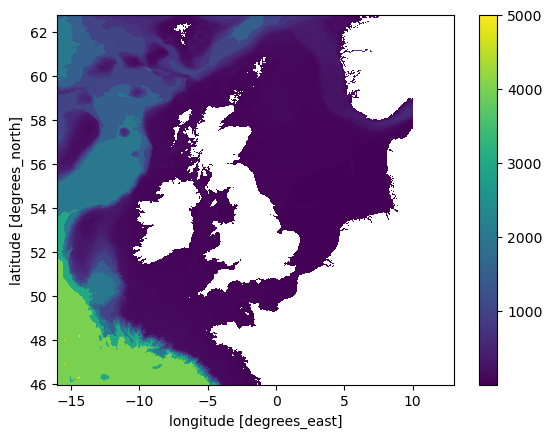

In [8]:
max_depth_curr = (ds_curr.depth * (~ds_curr.uo.isel(time=0, drop=True).isnull())).max("depth")
max_depth_curr = max_depth_curr.where(max_depth_curr > 0)
display(max_depth_curr)

max_depth_curr.plot()

In [9]:
max_depth_curr = max_depth_curr.assign_coords(
    hex_label=xr.apply_ufunc(
        hex_proj.lon_lat_to_hex_AoS,
        *xr.broadcast(max_depth_curr.lon, max_depth_curr.lat),
        output_dtypes=[tuple, ],
        dask="paralellized",
    ),
)

Need labels as strings for later lookup:

In [10]:
hex_label = max_depth_curr.hex_label
hex_label = xr.DataArray(
    np.array(list(map(str, hex_label.data.flatten()))).reshape(hex_label.data.shape),
    dims=hex_label.dims,
    name="hex_label",
)
hex_label

<xarray.DataArray 'hex_label' (lon: 958, lat: 1240)> Size: 67MB
array([['(-67, -16, 83)', '(-67, -16, 83)', '(-67, -16, 83)', ...,
        '(-44, 78, -34)', '(-44, 79, -35)', '(-44, 79, -35)'],
       ['(-67, -16, 83)', '(-67, -16, 83)', '(-67, -16, 83)', ...,
        '(-44, 78, -34)', '(-44, 78, -34)', '(-44, 79, -35)'],
       ['(-67, -16, 83)', '(-67, -16, 83)', '(-67, -16, 83)', ...,
        '(-44, 78, -34)', '(-44, 78, -34)', '(-44, 79, -35)'],
       ...,
       ['(82, -88, 6)', '(82, -88, 6)', '(82, -88, 6)', ...,
        '(54, 31, -85)', '(54, 31, -85)', '(54, 31, -85)'],
       ['(82, -88, 6)', '(82, -88, 6)', '(82, -88, 6)', ...,
        '(54, 31, -85)', '(54, 31, -85)', '(54, 31, -85)'],
       ['(82, -88, 6)', '(82, -88, 6)', '(82, -87, 5)', ...,
        '(54, 31, -85)', '(54, 31, -85)', '(54, 31, -85)']], dtype='<U14')
Dimensions without coordinates: lon, lat

### Aggregate depth and coverage stats

In [11]:
depth_mean = max_depth_curr.groupby(hex_label).mean()

In [12]:
depth_median = max_depth_curr.compute().groupby(hex_label).median()

In [13]:
depth_std = max_depth_curr.groupby(hex_label).std()

In [14]:
water_count = max_depth_curr.groupby(hex_label).count()

In [15]:
gridbox_count = xr.ones_like(max_depth_curr).groupby(hex_label).sum()

In [16]:
water_fraction = water_count / gridbox_count

### Select for relevant positions and include in connectivity dataset

In [17]:
import tqdm

In [18]:
for dt, cmf in tqdm.tqdm(enumerate(connectivity_matrix_file_list)):
    
    connectivity_matrix = xr.open_dataset(cmf)
    
    connectivity_matrix["water_fraction_hex0"] = water_fraction.sel(
        hex_label=connectivity_matrix.hex0.where(
            connectivity_matrix.lon_hex0 < 10_000, drop=True
        )
    )
    
    connectivity_matrix["water_fraction_hex1"] = water_fraction.sel(
        hex_label=connectivity_matrix.hex1.where(
            connectivity_matrix.lon_hex1 < 10_000, drop=True
        )
    )
    
    connectivity_matrix["gridbox_count_hex0"] = gridbox_count.sel(
        hex_label=connectivity_matrix.hex0.where(
            connectivity_matrix.lon_hex0 < 10_000, drop=True
        )
    )
    
    connectivity_matrix["gridbox_count_hex1"] = gridbox_count.sel(
        hex_label=connectivity_matrix.hex1.where(
            connectivity_matrix.lon_hex1 < 10_000, drop=True
        )
    )
    
    connectivity_matrix["water_count_hex0"] = water_count.sel(
        hex_label=connectivity_matrix.hex0.where(
            connectivity_matrix.lon_hex0 < 10_000, drop=True
        )
    )
    
    connectivity_matrix["water_count_hex1"] = water_count.sel(
        hex_label=connectivity_matrix.hex1.where(
            connectivity_matrix.lon_hex1 < 10_000, drop=True
        )
    )
    
    connectivity_matrix["depth_mean_hex0"] = depth_mean.sel(
        hex_label=connectivity_matrix.hex0.where(
            connectivity_matrix.lon_hex0 < 10_000, drop=True
        )
    )
    
    connectivity_matrix["depth_mean_hex1"] = depth_mean.sel(
        hex_label=connectivity_matrix.hex1.where(
            connectivity_matrix.lon_hex1 < 10_000, drop=True
        )
    )
    
    connectivity_matrix["depth_median_hex0"] = depth_median.sel(
        hex_label=connectivity_matrix.hex0.where(
            connectivity_matrix.lon_hex0 < 10_000, drop=True
        )
    )
    
    connectivity_matrix["depth_median_hex1"] = depth_median.sel(
        hex_label=connectivity_matrix.hex1.where(
            connectivity_matrix.lon_hex1 < 10_000, drop=True
        )
    )
    
    connectivity_matrix["depth_std_hex0"] = depth_std.sel(
        hex_label=connectivity_matrix.hex0.where(
            connectivity_matrix.lon_hex0 < 10_000, drop=True
        )
    )
    
    connectivity_matrix["depth_std_hex1"] = depth_std.sel(
        hex_label=connectivity_matrix.hex1.where(
            connectivity_matrix.lon_hex1 < 10_000, drop=True
        )
    )
    
    connectivity_matrix_file_out = Path(connectivity_matrix_file_out_path)/connectivity_matrix_file_out_pattern.format(dt=dt)
    
    connectivity_matrix.compute().to_netcdf(connectivity_matrix_file_out)

29it [42:52, 88.69s/it]


### Have a look

In [20]:
connectivity_matrix = xr.open_dataset("/gxfs_work/geomar/smomw400/git_projects/2022_north-sea_oysters/output_data/035_connection_count_05m/035_connection_count_05m_days-travelled-28_bio_phys_agg.nc")
connectivity_matrix

<xarray.Dataset> Size: 11GB
Dimensions:              (hex0: 8364, hex1: 8359, month: 5, year: 4, corner: 7)
Coordinates: (12/13)
  * hex0                 (hex0) <U14 468kB '(-1, -19, 20)' ... '(9, 9, -18)'
  * hex1                 (hex1) <U14 468kB '(-1, -19, 20)' ... '(9, 9, -18)'
  * month                (month) float64 40B 0.0 1.0 2.0 3.0 4.0
  * year                 (year) float64 32B 0.0 1.0 2.0 3.0
    lon_hex0_corners     (corner, hex0) float64 468kB ...
    lat_hex0_corners     (corner, hex0) float64 468kB ...
    ...                   ...
    lat_hex1_corners     (corner, hex1) float64 468kB ...
    lon_hex0             (hex0) float64 67kB ...
    lon_hex1             (hex1) float64 67kB ...
    lat_hex0             (hex0) float64 67kB ...
    lat_hex1             (hex1) float64 67kB ...
    hex_label            (hex0) <U14 468kB ...
Dimensions without coordinates: corner
Data variables: (12/25)
    aqc_count_hex0       (hex0) float64 67kB ...
    rst_count_hex0       (hex0) float64 67kB ...
    pop_count_hex0       (hex0) float64 67kB ...
    dss_count_hex0       (hex0) float64 67kB ...
    hly_count_hex0       (hex0) float64 67kB ...
    his_count_hex0       (hex0) float64 67kB ...
    ...                   ...
    depth_mean_hex0      (hex0) float32 33kB ...
    depth_mean_hex1      (hex1) float32 33kB ...
    depth_median_hex0    (hex0) float64 67kB ...
    depth_median_hex1    (hex1) float64 67kB ...
    depth_std_hex0       (hex0) float32 33kB ...
    depth_std_hex1       (hex1) float32 33kB ...
Attributes:
    hex_proj__lon_origin:       -3.0
    hex_proj__lat_origin:       54.5
    hex_proj__hex_size_meters:  10000